In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import tensorflow as tf


%matplotlib inline

In [2]:
def download_file(url, local_loc):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    output_file = local_loc+"/"+local_filename
    with open(output_file, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return output_file

In [6]:
def download_data():
    loc = '../data/'
    train_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
    test_url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
    train_file = train_url.split("/")[-1]
    test_file = test_url.split("/")[-1]
    if test_file not in os.listdir(loc) and train_file not in os.listdir(loc):
        train_data = download_file(train_url, local_loc)
        test_data = download_file(test_url, local_loc)
    train_data = loc+train_file
    test_data = loc+test_file
    return train_data,test_data

In [7]:
train_input, test_input = download_data()

In [8]:
data = sio.loadmat(train_input)

In [9]:
X = data['X']
y = data['y']
y[y==10] = 0

In [13]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 32, 32, 3])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(inputs=input_layer,
                             filters=32,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [14]:
image_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model", )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_tf_random_seed': None, '_session_config': None, '_save_checkpoints_secs': 600, '_service': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_model_dir': '/tmp/mnist_convnet_model', '_save_summary_steps': 100, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1095a4c18>, '_train_distribute': None, '_save_checkpoints_steps': None, '_master': '', '_is_chief': True}


In [19]:
train_index = np.random.choice(range(73257), size=40000, replace=False)
test_index = np.array(list(set(range(73257)).difference(set(train_index))))

In [20]:
train_data = []
for i in train_index:
    train_data.append(X[:,:,:,i])
train_data = np.array(train_data).astype(np.float32)# Returns np.array
train_labels = np.asarray(y[train_index,0], dtype=np.int32)

eval_data = []
for i in test_index:
    eval_data.append(X[:,:,:,i])
eval_data = np.array(eval_data).astype(np.float32)# Returns np.array
eval_labels = np.asarray(y[test_index,0], dtype=np.int32)

In [21]:
#tensors_to_log = {"probabilities": "softmax_tensor"}
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=500)

In [23]:
np.random.seed(1)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                    y=train_labels,batch_size=100,num_epochs=None,shuffle=True)
image_classifier.train(input_fn=train_input_fn,steps=2000,hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-15187
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 15188 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:
INFO:tensorflow:step = 15188, loss = 2.1159608
INFO:tensorflow:Saving checkpoints for 15287 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 2.2883277.


In [24]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data[:1000]},
    y=eval_labels[:1000],
    num_epochs=1,
    shuffle=False)
eval_results = image_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-19-02:42:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-15287
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-19-02:42:15
INFO:tensorflow:Saving dict for global step 15287: accuracy = 0.21, global_step = 15287, loss = 2.198936
{'accuracy': 0.21, 'loss': 2.198936, 'global_step': 15287}


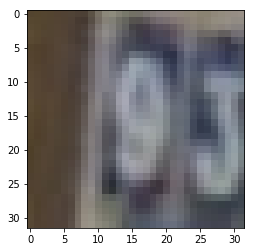

In [33]:
plt.imshow(eval_data[1].astype(int))